# Feature Matching & Image Stitching

Wir brauchen zwei Bilder, die sich überlappen. Wir simulieren das, indem wir ein großes Bild nehmen und es künstlich zerschneiden/transformieren, oder wir laden zwei echte Fotos, z. B. einer Berglandschaft.


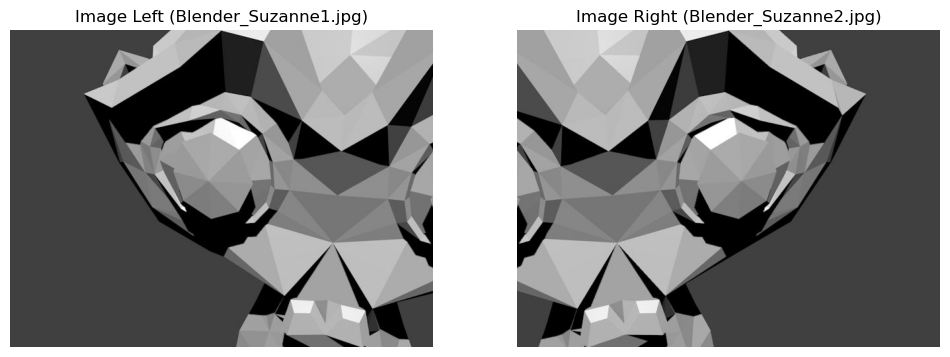

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def load_local_image(filepath):
    # Check if file exists
    if not os.path.exists(filepath):
        print(f"Error: File not found at {filepath}")
        return None

    # Load image in BGR format
    img = cv2.imread(filepath)

    # Convert from BGR (OpenCV standard) to RGB (Matplotlib standard)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Define local filenames (assumes images are in the same folder as this script)
file_left = "Blender_Suzanne1.jpg"
file_right = "Blender_Suzanne2.jpg"

# Load images
img1 = load_local_image(file_left)  # Image A (Query)
img2 = load_local_image(file_right) # Image B (Train)

if img1 is not None and img2 is not None:
    # Trigger feature selection visualization (optional context)
    #

    # Display images
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.title("Image Left (Blender_Suzanne1.jpg)")
    plt.axis('off') # Hide axes for cleaner look

    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.title("Image Right (Blender_Suzanne2.jpg)")
    plt.axis('off')

    plt.show()
else:
    print("Could not load images. Please check the file paths.")


# Features finden (SIFT)

Wir suchen nach den markanten Punkten.

Gefundene Keypoints Bild 1: 420
Gefundene Keypoints Bild 2: 481


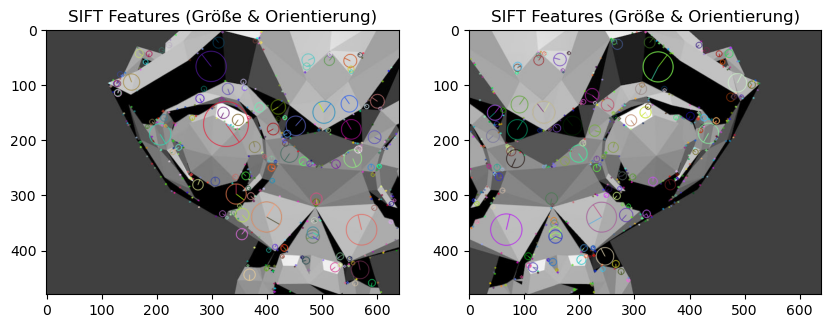

In [ ]:

# 1. Graustufen (Features brauchen keine Farbe)
gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

# 2. SIFT Initialisieren
sift = cv2.SIFT_create()

# 3. Keypoints und Deskriptoren finden
# kp = Liste von Keypoints (Position, Größe, Winkel)
# des = Numpy Array (Anzahl_Keypoints x 128)
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

print(f"Gefundene Keypoints Bild 1: {len(kp1)}")
print(f"Gefundene Keypoints Bild 2: {len(kp2)}")

# Visualisierung der Features auf Bild 1
img1_kp = cv2.drawKeypoints(img1, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2_kp = cv2.drawKeypoints(img2, kp2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(img1_kp); plt.title("SIFT Features (Größe & Orientierung)")
plt.subplot(1, 2, 2)
plt.imshow(img2_kp); plt.title("SIFT Features (Größe & Orientierung)")
plt.show()

# Große Kreise = Features auf grober Skala (unscharf),
# kleine Kreise = feine Details.
# Der Strich im Kreis zeigt die Orientierung.


# Matching (Die Nadel im Heuhaufen)

Wir nutzen FLANN (Fast Library for Approximate Nearest Neighbors), da Brute-Force bei 2000+ Punkten zu langsam sein kann


Anzahl roher Matches: 420


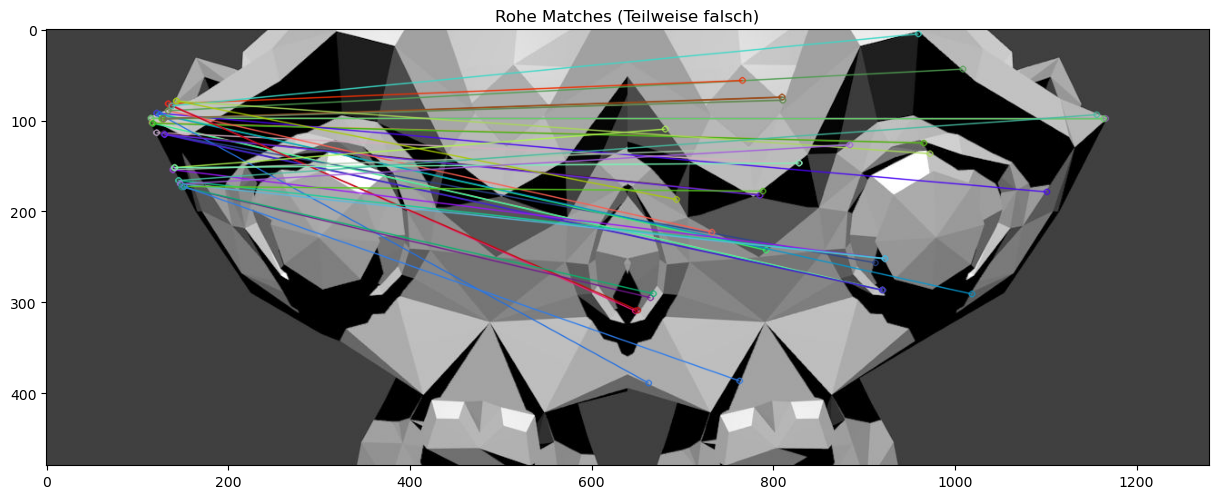

In [ ]:

# FLANN Parameter (Magie für KD-Trees)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50) # Wie genau soll gesucht werden?

flann = cv2.FlannBasedMatcher(index_params, search_params)

# k=2: Wir wollen die 2 besten Matches für jeden Punkt (für den Ratio Test)
matches = flann.knnMatch(des1, des2, k=2)

print(f"Anzahl roher Matches: {len(matches)}")

# Visualisierung der ersten 20 Matches (Ohne Filterung - CHAOS!)
img_matches_raw = cv2.drawMatchesKnn(img1, kp1, img2, kp2, matches[:20], None, flags=2)
plt.figure(figsize=(15, 6))
plt.imshow(img_matches_raw); plt.title("Rohe Matches (Teilweise falsch)")
plt.show()

# Die Spreu vom Weizen trennen (Lowe's Ratio Test)

Gute Matches nach Filterung: 132


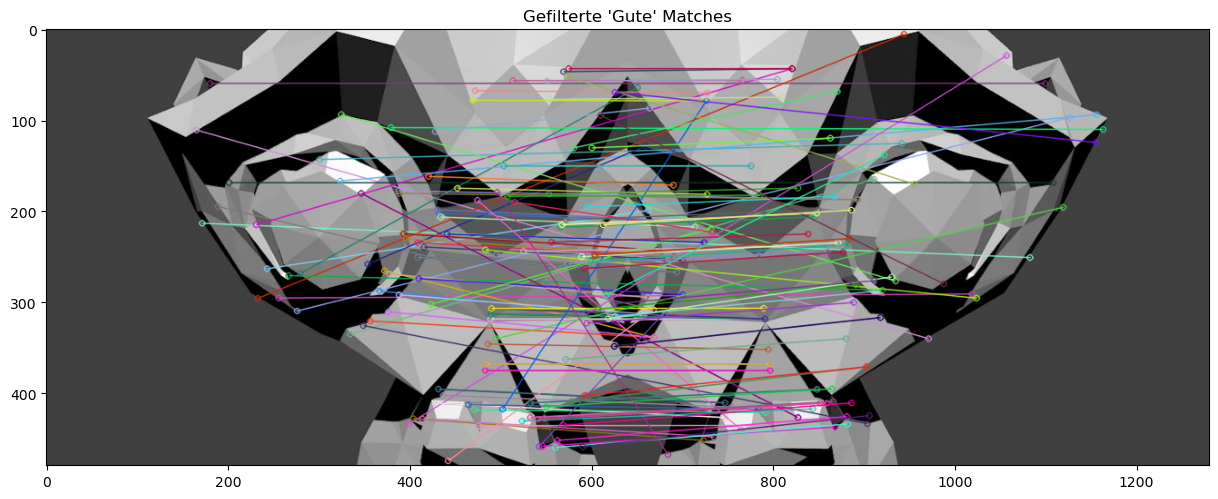

In [ ]:
good_matches = []

# Lowe's Ratio Test
# Ein Match ist nur gut, wenn der nächstbeste Match viel schlechter ist.
# m = Bester Match, n = Zweitbester Match
for m, n in matches:
    if m.distance < 0.75 * n.distance: # 0.75 ist ein guter Erfahrungswert
        good_matches.append(m)

print(f"Gute Matches nach Filterung: {len(good_matches)}")

# Visualisierung der guten Matches
img_matches_good = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=2)
plt.figure(figsize=(15, 6))
plt.imshow(img_matches_good); plt.title("Gefilterte 'Gute' Matches")
plt.show()

# Die Homografie finden (RANSAC)

Jetzt berechnen wir die Transformationsmatrix, die Bild 1 so verzerrt, dass es auf Bild 2 passt.
Wir nutzen RANSAC (Random Sample Consensus), um Ausreißer (falsche Matches, die durch den Filter geschlüpft sind) zu ignorieren.


In [ ]:

MIN_MATCH_COUNT = 10

if len(good_matches) > MIN_MATCH_COUNT:
    # --- WICHTIGE ÄNDERUNG HIER ---
    # Wir wollen Bild 2 (Rechts) so transformieren, dass es an Bild 1 (Links) passt.
    # Daher ist src_pts jetzt Bild 2 (trainIdx) und dst_pts ist Bild 1 (queryIdx).

    src_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)

    # Berechnen der Homografie-Matrix M
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    matchesMask = mask.ravel().tolist()

    print("Homografie-Matrix M (3x3):")
    print(M)
else:
    print(f"Nicht genug Matches gefunden - {len(good_matches)}/{MIN_MATCH_COUNT}")
    M = None

Homografie-Matrix M (3x3):
[[ 5.94704105e-01 -1.38492538e-01  4.05829007e+02]
 [ 8.41847047e-03  9.22541310e-01 -8.79934790e-01]
 [-6.30079573e-04  5.85590599e-05  1.00000000e+00]]


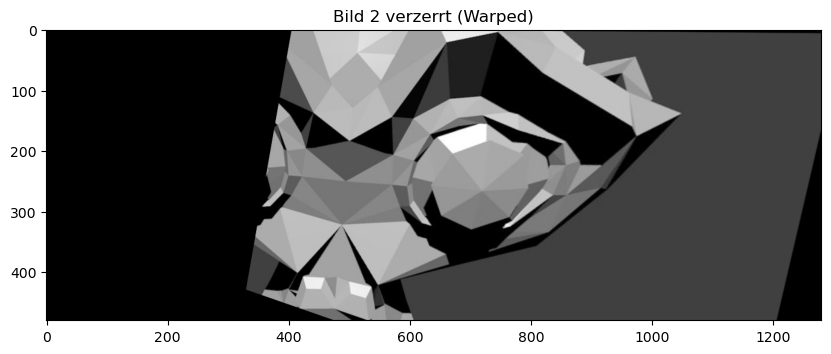

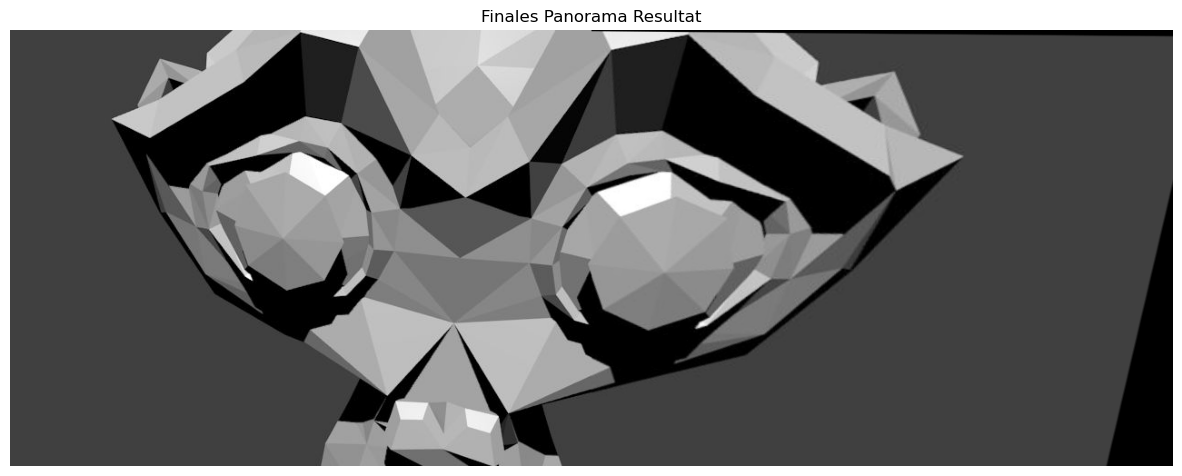

In [ ]:
# Warping & Stitching (Das Finale)

# Wir wenden die Matrix $M$ auf Bild 1 an und legen Bild 2 daneben.

if M is not None:
    # Dimensionen des Panoramas berechnen
    # Wir nehmen die Breite beider Bilder zusammen
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    # WARPING: Wir verzerren Bild 2 (Rechts) mit der Matrix M, damit es an Bild 1 passt
    # Die Breite des Canvas ist w1 + w2, damit genug Platz nach rechts ist
    dst = cv2.warpPerspective(img2, M, (w1 + w2, h1))

    # Anzeigen des verzerrten Bildes 2 (Es sollte jetzt nach links verschoben/rotiert sein)
    plt.figure(figsize=(10, 6))
    plt.imshow(dst); plt.title("Bild 2 verzerrt (Warped)")
    plt.show()

    # STITCHING: Wir kopieren das unveränderte Bild 1 (Links) an den Anfang (0,0)
    # Da Bild 1 unser Anker ist, bleibt es unberührt.
    dst[0:h1, 0:w1] = img1

    # Optional: Schwarze Ränder rechts entfernen (wie gehabt)
    gray_dst = cv2.cvtColor(dst, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray_dst, 1, 255, cv2.THRESH_BINARY)
    x, y, w_crop, h_crop = cv2.boundingRect(thresh)
    final_result = dst[y:y+h_crop, x:x+w_crop]

    plt.figure(figsize=(15, 8))
    plt.imshow(final_result); plt.title("Finales Panorama Resultat")
    plt.axis('off')
    plt.show()
else:
    print("Stitching fehlgeschlagen.")